# <font color='Blue'>Session 5: neural networks</font>

Previously:
- Reservoir simulation with DARTS 
- Techno-economics

Today, Learning objectives:
- train a neural network
- deploy proxy  to optimizer

Some useful resources about Machine learning:
- TensorFlow website, Basic regression: Predict fuel efficiency. url: https://www.tensorflow.org/tutorials/keras/regression#regression_with_a_deep_neural_network_dnn
- Deep Learning by Ian Goodfellow and Yoshua Bengio and Aaron Courville. url: https://www.deeplearningbook.org/
- Hands-on 
Machine Learning
 with Scikit-Learn 
Keras & TensorF by Aurélien Géron. url: https://tudelft.on.worldcat.org/search/detail/1124929613?queryString=Hands-on%20Machine%20Learning%20with%20Scikit-Learnlow

<img style="float: left;" src="perm.PNG" width="40%">
<img style="float: left;" src="pressure.PNG" width="40%">

In [1]:
# import necessary python packages
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf 
import pandas as pd 
#import math 

from scipy import linalg
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

## <font color='Blue'>Classes</font>

In [2]:
class optimizer():
    def __init__(self, wells, NN, mu, min_max):
        """ 
        ENSEMBLE OPTIMIZATION OF A GEOTHERMAL DOUBLET:
            control vector     : u [1 x Nu] e.g. well locations, well bhp, rates.
            objective function : Levelized Cost of Heat (LCOH) in euro/MWh 
        """

        self.NN = NN
        self.mu = mu 
        self.min_max = min_max 
        
        # control vector paramaters 
        self.Nt = 1                 # number of control time intervals
        self.Nw = len(wells)//2     # number of controlled wells
        # self.Nw = 1 
        self.Nu = self.Nt*self.Nw   # total number of controls
        self.wells = wells
        
        # optimization parameters
        self.Np = self.Nu + 0   # number of perturbations (must be greater than Nu)
        self.perturb = 1.0      # perturbation magnitude
        self.Nc = 0             # correlation length
        
        # scaling factors 
        self.su = 1e3
        self.Su = self.su * np.eye(self.Nu)  # scaling factor for control vector 
        self.Sj = 1e0                        # scaling factor for objective function 
        
        self.u = np.zeros(self.Nu)  # control vector
        self.a = np.zeros(self.Nu)  # vector of lower bounds
        self.b = np.zeros(self.Nu)  # vector of upper bounds
        self.ref = 4000 
        self.max = 10000            # maximum allowed control rate
        self.min = 4000              # minimum allowed control rate
        
        # self.u[0:self.Nu] = self.ref # control vector 
        #np.random.seed(1)
        self.u = self.ref + (self.su*self.perturb)*np.random.randn(self.Nw) 
        self.a[0:self.Nu] = self.min   # lower bound
        self.b[0:self.Nu] = self.max   # upper bound 
        
        # production well
        # self.u[3:] = self.ref 
        # self.a[3:] = self.min
        # self.b[3:] = self.max
        
        # scale control vector 
        self.a /= self.su
        self.u /= self.su
        self.b /= self.su
                
    def calculate_obj(self, x):
        """ calculate objective functions """
        obj = self.NN.model((x.reshape(1, self.Nu) - mu)/min_max).numpy()[0][0]
        return obj
         
    def covariance(self):
        Cw = np.eye(self.Nt)
        if self.Nc > 0:
            for i in range(self.Nt):
                for j in range(i+1, self.Nt, 1):
                    Cw[i,j] = np.exp(-(i-j)**2/self.Nc**2)
                    Cw[j,i] = Cw[i,j]
        C = Cw
        for i in range(1, self.Nw, 1):
            C = linalg.block_diag(C,Cw)

        return C
    
    def perturbation(self, u):
        """
        Random distributed perturbations for ensemble gradients generate an ensemble 
        of control vectors based on uncorrelated Gaussian-distributed perturbations.
        This functions returns the Nu x Np matrix U containing perturbed controls.
        
        u         current control vector
        a         vector with lower bounds
        b         vector with upper bounds
        perturb   perturbation magnitude
        Np        number of perturbations
        """
        
        U = np.zeros((self.Nu, self.Np))
        # np.random.seed(1234)
        p = np.random.randn(self.Nu, self.Np)
        u = u.reshape((self.Nu, 1))
        U = np.tile(u,(1, self.Np)) + self.perturb*p
        U = self.truncate(U)
        
        return U
    
    def truncate(self, U):
        """
        This function truncates controls at the bounds
        U         matrix with control vectors
        a         vector with lower bounds
        b         vector with upper bounds
        """
        
        for j in range(U.shape[1]):
            ui   = U[:,j]
            for i in range(self.Nu):    
                if ui[i] < self.a[i]:
                    ui[i] = self.a[i]
                if ui[i] > self.b[i]:
                    ui[i] = self.b[i]
                U[:,j] = ui
                
        return U
    
    def compute_gradient(self, u, J, U):
        """
        This function returns the approximate gradient g of an objective function with respect to the controls u.
        u         current control vector
        J         current objective function value
        U         ensemble of perturbed controls
        Nt        number of control time intervals
        Su        scaling matrix for controls
        Sj        scaling factor for objective function values
        g         gradient estimate
        """

        # evaluate the objective function values for all perturbed control vectors
        jo = np.nan*np.ones((self.Np,1))    
        for i in range(self.Np): 
            # use neural network
            objval = self.calculate_obj(U[:,i])
            jo[i]  = objval/self.Sj

        # anomalies and assign to matrix U and vector j
        u  = u.reshape((self.Nu, 1))
        dU = U - np.tile(u, (1,self.Np)) 
        dU = np.transpose(dU)
        dj = jo - np.tile(J,(self.Np,1))
        
        # Singular Value Decomposition
        X, S, Vh = linalg.svd(dU, full_matrices=False)
        S = np.diag(S)
        V = Vh.T

        E  = np.sum(np.sum(S**2))
        E1 = 0
        p  = 0
        S1 = np.zeros(np.shape(S))
        for i in range(np.min(np.shape(S))):
            if E1/E < 0.999:
                E1 = E1 + S[i,i]**2
                if S[i,i] > 0:
                    S1[i,i] = 1/S[i,i]
                    p = p + 1
        
        # compute gradient
        g = np.dot(np.dot(np.dot(V[:,0:p] , S1[0:p,0:p]) , X[:,0:p].T), dj)
            
        return g, jo
    
    def update(self, u, alpha, g):
        """
        Ths function computes a step size and performs a steepest ascent update
        u         current control vector
        alpha     proposed step size
        g         (preconditioned) gradient vector
        a         vector with lower bounds
        b         vector with upper bounds
        """
        u = u.reshape((self.Nu, 1))
        s = g # use the (preconditioned) gradient as the search direction       
        dl = self.a.reshape(self.Nu, 1) - u
        du = self.b.reshape(self.Nu, 1) - u
        
        # set outward directed gradient components to 0 when control is on bound    
        for i in range(len(s)):
            if (du[i]<=0 and s[i]<0) or (dl[i]>=0 and s[i]<0):
                s[i] = 0
        
        # scale s such that the absolute value of the largest element is equal to 1
        if max(abs(s)) > 0:
            s = s / max(abs(s))
        
        # maximum steplength such that a - epsilon <= u + alpha * s <= b + epsilon
        i = np.where(s != 0)
        epsilon = 0.05
        alpha1  = np.min(
            np.min([abs((dl[i]-epsilon)/s[i]),  abs((du[i]+epsilon)/s[i])])
            )
        
        if not alpha1:
            alpha = min([alpha, alpha1])
        
        # (preconditioned) steepest ascent update
        u1 = u + alpha * s
                          
        # truncate the updated controls at the lower and upper bounds
        u1 = self.truncate(u1)
        
        return u1

class NeuralNetwork:
    def __init__(self, train_xn, train_y, test_xn, test_y):#, normalize = False):
        """
        Initialize class
        -----------------------------------------------------------------------------------------
        train_xn : normalized input data for training,
            Size = [m x n_in], m = nr. of training samples, n_in = nr. of input features.
        train_y  : labels/target of training data,
            Size = [m x n_out], m = nr. of training samples, n_out = nr. of input features.
        test_xn  : normalized input of test data,
            Size = [m x n_in], m = nr. of training samples, n_in = nr. of input features.
        test_y   : labels/target of test data, n_out = nr. of input features.
        """
        # Call base class constructor
        super().__init__()
        
        # training data 
        self.train_x = train_xn 
        self.train_y = train_y 
        
        # test data 
        self.test_x = test_xn 
        self.test_y = test_y
        
        # # prepare training data 
        # training_data = tf.random.shuffle(temp, seed=131154, name=None) # shuffle data 
        # self.train_x = training_data[:,:3] 
        # self.train_y = training_data[:,3:] 

        # # prepare validation/test data 
        # test_data = tf.random.shuffle(temp_test, seed=250398, name=None) # shuffle data
        # self.test_x = test_data[:,:3]
        # self.test_y = test_data[:,3:]
        
        # if normalize:
        #     self.mu       = tf.reduce_mean(self.train_x, axis = 0) 
        #     self.min_max  = tf.reduce_max(self.train_x, axis = 0) - tf.reduce_min(self.train_x, axis = 0) 
        #     self.train_xn = (self.train_x - self.mu) / self.min_max
        #     self.test_xn  = (self.test_x - self.mu) / self.min_max
        # else:
        #     self.train_xn = self.train_x
        #     self.test_xn  = self.test_x 
    
    def create_model(self, n_units = 10, nl = 2, act = 'tanh'):
        """
        Function to build neural network architecture. 
        n_units : number of neurons per hidden layer 
        nl      : number of hidden layers 
        act     : activation function 
        """
        seed = 11194 # seed so the initial weights of the layers are random but predictable
        
        self.model = keras.Sequential() 

        # input layer
        self.model.add(keras.layers.Dense(units = self.train_x.shape[1], 
                                     kernel_initializer = tf.initializers.GlorotNormal(seed=seed),
                                     bias_initializer = 'zeros', 
                                     activation = 'linear', 
                                     name = 'input', 
                                     input_shape = (self.train_x.shape[1],)))   
        
        # hidden layers 
        for i in range(nl):
            self.model.add(keras.layers.Dense(units = n_units,
                                              kernel_initializer = tf.initializers.GlorotNormal(seed=seed),
                                              #bias_initializer = 'zeros',
                                              activation = act
                                              ))
            # self.model.add(keras.layers.LeakyReLU())

        # output layer 
        self.model.add(keras.layers.Dense(units = self.train_y.shape[1], 
                                     kernel_initializer = tf.initializers.GlorotNormal(seed=seed),
                                     bias_initializer = 'zeros', 
                                     activation = 'linear',
                                     name = 'output'))
        
        return self.model

    
    def load_model(self, loc):
        """
        Function to load pre-existing model 
        loc : file location and name 
        """
        self.model = tf.keras.models.load_model(loc)
        return self.model

    def save_model(self, loc):
        """
        function to save trained model
        loc : file location
        """
        tf.keras.models.save_model(loc)
        return 0
        
    def custom_loss(self, y_true, y_pred):
        """
        Function for defining custom loss functions. Pass to 'custom_loss' in compile model function.
        y_true : labels/truth  
        y_pred : neural network prediction 
        """
        L1 = tf.reduce_mean(tf.math.square(y_pred - y_true), axis = -1)
        return L1 
         
    def compile_model(self, lr0, decay_rate = 1, decay_steps = 1000, custom_metrics = None, custom_loss = 'MSE'):
        """
        Function to define optimizer and, loss function, metrics and compile. 
        lr0            : initial learning rate 
        decay_rate     : exponential decay rate
        decay_steps    : number of steps !not the same as the number of epochs! ~= nr_epochs / (nr_samples / batch_size)
        custom_metrics : user specified performance metric to monitor neural networks training with
        cutsom_loss    : custom loss function, default Mean Squared Error 
        """
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            lr0,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=False)
        
        self.optimizer = tf.keras.optimizers.Adam(self.lr_schedule) # stochastic optimizer 
        self.model.compile(loss = custom_loss,
                           optimizer = self.optimizer,
                           metrics = custom_metrics) 
        
    def train_model(self, nr_epochs, batch_size = 32, es = None):
        """
        function call for training neural network 
        nr_epochs  : number of epochs (training iterations) 
        batch_size : default 32, number of updates per epoch = nr_samples/batch_size 
        es         : callback for early stopping function, prevents overfitting 
        """
        # exponential_decay_fn = self.exponential_decay(lr0 = 1e-2, s = 250)
        # self.lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
        history = self.model.fit(self.train_x, 
                                 self.train_y,
                                 validation_data = (self.test_x, self.test_y),
                                 batch_size = batch_size,
                                 epochs = nr_epochs,
                                 verbose = 1, 
                                 callbacks = es,
                                 # use_multiprocessing = False
                                 )
        return history.history

## <font color='Blue'>Example 1: neural network</font>
<img style="float: left;" src="geothermal.PNG" width="80%">

***Import data***

In [ ]:
# load test data 
test_data = pd.read_pickle('session5data/test_data.pkl')

flist = []
for i in range(25):
    flist.append('session5data/darts_time_data%d.pkl'%i)    

# load training data
dfs = []
for file in flist:
    df = pd.read_pickle(file)
    df['Simulation'] = 'darts_time_data%d.pkl'%i
    dfs.append(df)
   
# compile single dataframe
data = pd.concat(dfs)

# reset index to avoid duplicate entries
data.reset_index(drop=True, inplace=True)

# check that we have the simulations as expected
data['Simulation'].unique()

data.columns.tolist()

In [ ]:
well_names = ['PRD1', 'PRD2']
plt.figure(figsize = (9,9))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
for i, w in enumerate(well_names):
    # temperature 
    plt.subplot(2,2,1)
    plt.grid()
    plt.scatter(data['time (a)'], data[w + ' : water rate (m3/day)'], s = 4, alpha = 0.5, label = w + ': train') 
    plt.plot(test_data['time (a)'], test_data[w + ' : water rate (m3/day)'], '-k', label = w + ': test')
    plt.ylabel('water rate (m3/day)')
    plt.xlabel('time (a)')
    plt.legend(bbox_to_anchor=(0, 0))   
    
    # BHP
    plt.subplot(2,2,2)
    plt.grid()
    plt.scatter(data['time (a)'], data[w + ' : BHP (bar)'], s = 4, alpha = 0.5, label = w + ": train")
    plt.plot(test_data['time (a)'], test_data[w + ' : BHP (bar)'], '-k', label = w + ': test')
    plt.ylabel('BHP (bar)')
    plt.xlabel('time (a)')
    plt.legend(bbox_to_anchor=(1, 1))
    
    # rates
    plt.subplot(2,2,3)
    plt.grid()
    plt.scatter(data['time (a)'], data[w + ' : temperature (K)'], s = 4, alpha = 0.5, label = w + ': train')
    plt.plot(test_data['time (a)'], test_data[w + ' : temperature (K)'], '-k', label = w + ': test')
    plt.ylabel('temperature (K)')
    plt.xlabel('time (a)')
    plt.legend(bbox_to_anchor=(0, 0)) 
    
# lcoh 
plt.subplot(2,2,4)
plt.scatter(data['time (a)'], data['LCOH'], s = 4, alpha = 0.5, label = 'train') 
plt.plot(test_data['time (a)'], test_data['LCOH'], '-k', label = 'test')
plt.ylabel('LCOH (euro/MWh)')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('time (a)')
plt.show()

***Prepare data***

In [ ]:
# define training data 
train_x  = np.vstack([
    data['time (a)'],
    data['INJ1 : water rate (m3/day)'], 
    data['INJ2 : water rate (m3/day)']
    ]).T
train_y  = np.vstack([
    data['PRD1 : temperature (K)'], 
    data['PRD2 : temperature (K)'],
    #data['LCOH'], 
    ]).T 

# define test data 
test_x  = np.vstack([
    test_data['time (a)'],
    test_data['INJ1 : water rate (m3/day)'], 
    test_data['INJ2 : water rate (m3/day)']
    ]).T
test_y  = np.vstack([
    test_data['PRD1 : temperature (K)'], 
    test_data['PRD2 : temperature (K)'],
    #test_data['LCOH'], 
    ]).T 

# train_y  = np.vstack([
#     -(data['PRD1 : energy (kJ/day)'] + data['PRD2 : energy (kJ/day)']) - (data['INJ1 : energy (kJ/day)'] + data['INJ2 : energy (kJ/day)'])
#                       ]).T 

n = train_x.shape[0] # number of input features
m = train_x.shape[1] # number of training samples

# normalize data 
mu       = train_x.mean(axis = 0)
min_max  = train_x.max(axis = 0) - train_x.min(axis = 0)
train_xn = (train_x - mu)/min_max
test_xn  = (test_x - mu)/min_max

train_y

***Construct neural network***

In [ ]:
# define hyperparameters 
nl  = 4         # number of hidden layers 
nu  = 20        # number of neurons per layer
act = 'tanh'    # activation function 
lr0 = 1e-3      # learning rate 

NN = NeuralNetwork(train_xn, train_y-350, test_xn, test_y-350)
NN.create_model(n_units = nu, nl = nl) # create model 
NN.model.summary() 
NN.compile_model(lr0, decay_rate = 1, decay_steps = 32000, custom_metrics = None, custom_loss = 'MSE')

***Train neural network***

During training the collection of weights and biases is updated to minimize the loss function. The loss function is defined as the mean squared error the of the neural networks prediction and the corresponding label. 

In [ ]:
batch_size = 32 
nr_epochs = 250 # number of epochs/training iterations 
history = NN.train_model(nr_epochs, 
                         batch_size = batch_size, 
                         es = None)

plt.figure(figsize = (12,4)) 
plt.subplot(1,2,1)
plt.grid()
plt.semilogy(history['loss'], label = 'training loss')
plt.semilogy(history['val_loss'], label = 'test loss') 
plt.xlabel('epoch') 
plt.ylabel('loss - MSE')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (6,2), dpi = 100)
plt.subplots_adjust(wspace = 0.4)
plt.subplot(1,2,1)
plt.grid()
plt.title('Training')
plt.plot(train_x[:,0], train_y, '.r')
plt.plot(train_x[:,0], NN.model(train_xn) + 350,'.k', alpha = 0.1)
plt.xlabel('time (a)')
#plt.ylabel('T (K)')
plt.subplot(1,2,2)
plt.grid()
plt.title('Test')
plt.plot(test_x[:,0], test_y, '-r')
plt.plot(test_x[:,0], NN.model(test_xn) + 350 ,'--k')
plt.xlabel('time (a)')
#plt.ylabel('T (K)')
plt.show()

plt.figure(figsize = (6,2), dpi = 100)
plt.subplots_adjust(wspace = 0.4)
plt.subplot(1,2,1)
plt.title('Training')
plt.grid()
plt.plot(train_y, NN.model(train_xn) + 350, '.')
plt.xlabel('y')
plt.ylabel(r'$y_{\theta}$')
#plt.legend(['PRD1', 'PRD2'])
plt.subplot(1,2,2)
plt.title('Test')
plt.grid()
plt.plot(test_y, NN.model(test_xn) + 350, '.')
plt.xlabel('y')
plt.ylabel(r'$y_{\theta}$')
#plt.legend(['PRD1', 'PRD2'])
plt.show()

## <font color='Blue'>Example 2: optimization</font>

In this optimization problem we define the controls as the rates per doublet and the objective function (aka the cost function) as the levelized cost of heat. Here, we assume that the rate is constant for 30years.

<img style="float: left;" src="geothermal2.PNG" width="80%">

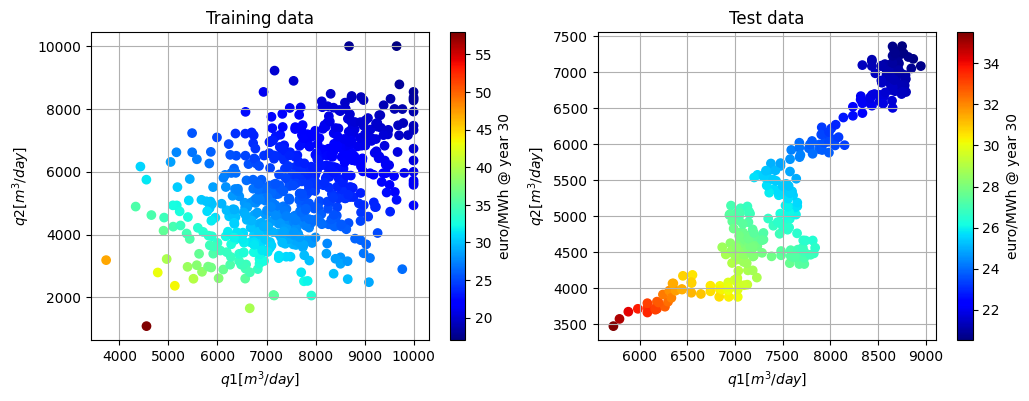

In [3]:
# import training set
train_x = np.load('session5data/data_x_model2.npy')*1e3 # m3/day
train_y = np.load('session5data/data_y_model2.npy').reshape(-1,1) # levelized cost of heat euro/MWh

# import test set
test_x = np.load('session5data/u_2.npy')*1e3 # well rates [INJ1, INJ2] ,  m3/day
test_y = np.load('session5data/j_2.npy').reshape(-1,1) # levelized cost of heat euro/MWh

plt.figure(figsize = (12,4)) 
plt.subplot(1,2,1)
plt.grid()
plt.title('Training data')
c = plt.scatter(train_x[:,0], train_x[:,1], c = train_y, cmap = 'jet') 
plt.colorbar(c, label = 'euro/MWh @ year 30')
plt.xlabel(r'$q1 [m^3/day]$')
plt.ylabel(r'$q2 [m^3/day]$')
plt.subplot(1,2,2)
plt.title('Test data') 
plt.grid()
c = plt.scatter(test_x[:,0], test_x[:,1], c = test_y, cmap = 'jet') 
plt.colorbar(c, label = 'euro/MWh @ year 30')
plt.xlabel(r'$q1 [m^3/day]$')
plt.ylabel(r'$q2 [m^3/day]$')
plt.show()

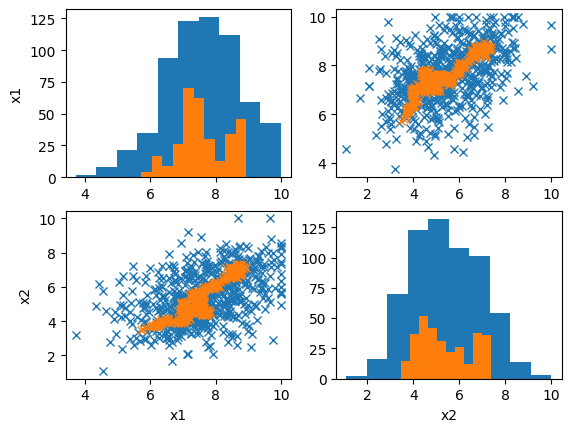

In [4]:
# normalize training data 
#mu = np.mean(train_x, axis = 0) 
#min_max = train_x.max(axis = 0) - train_x.min(axis = 0) 

mu       = 0
min_max  = 1e3
train_xn = (train_x - mu) / min_max
test_xn  = (test_x - mu) / min_max 

plt.figure(dpi = 100)
plt.subplot(2,2,1) 
plt.hist(train_xn[:,0]) 
plt.hist(test_xn[:,0])
plt.ylabel('x1')
plt.subplot(2,2,2)
plt.plot(train_xn[:,1], train_xn[:,0], 'x') 
plt.plot(test_xn[:,1], test_xn[:,0], 'x') 
plt.subplot(2,2,3) 
plt.plot(train_xn[:,0], train_xn[:,1], 'x') 
plt.plot(test_xn[:,0], test_xn[:,1], 'x')
plt.xlabel('x1') 
plt.ylabel('x2')
plt.subplot(2,2,4) 
plt.hist(train_xn[:,1]) 
plt.hist(test_xn[:,1])
plt.xlabel('x2') 
plt.show() 

In [5]:
nl  = 2  # number of hidden layers 
nu  = 10 # number of neurons per layer 
act = 'tanh' # activation function 
lr0 = 1e-3 # learning rate 

NN = NeuralNetwork(train_xn, train_y/1e2, test_xn, test_y/1e2)
NN.create_model(n_units = nu, nl = nl) # create model 
NN.model.summary() 
NN.compile_model(lr0, decay_rate = 0.1, decay_steps = 32000, custom_metrics = None, custom_loss = 'MSE')

C:\Users\georgehadjisot\Documents\Anaconda\envs\opendarts\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,347 (5.26 KB)

 Trainable params: 1,347 (5.26 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# train neural network
batch_size = 32 
nr_epochs = 200 # number of epochs
history = NN.train_model(nr_epochs, batch_size = 32, es = None)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5054e-06 - val_loss: 6.3458e-06
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9571e-06 - val_loss: 8.0017e-06
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3157e-06 - val_loss: 8.8081e-07
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7342e-06 - val_loss: 2.1328e-07
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9574e-06 - val_loss: 1.0450e-06
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1500e-06 - val_loss: 1.0638e-07
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8746e-06 - val_loss: 1.8317e-06
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7264e-06 - val_loss: 4.2907e-06
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7686e-06 - val_loss: 2.6722e-06
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8749e-06 - val_loss: 2.1381e-06
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8585e-0

KeyboardInterrupt: 

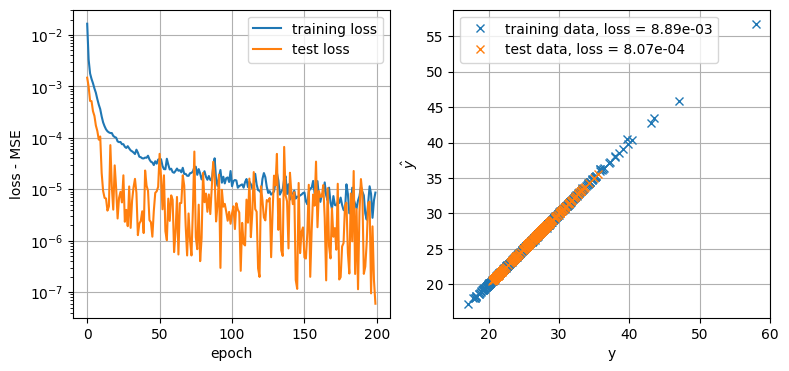

In [18]:
plt.figure(figsize = (9,4)) 
plt.subplot(1,2,1)
plt.grid()
plt.semilogy(history['loss'], label = 'training loss')
plt.semilogy(history['val_loss'], label = 'test loss') 
plt.xlabel('epoch') 
plt.ylabel('loss - MSE')
plt.legend()
plt.subplot(1,2,2)
plt.grid()
loss_fn = keras.losses.MeanSquaredError() 
loss_training = loss_fn(train_y, 1e2*NN.model(train_xn))
loss_test = loss_fn(test_y, 1e2*NN.model(test_xn))
plt.plot(train_y, 1e2 * NN.model(train_xn), 'x', label = 'training data, loss = %.2e'%loss_training)
plt.plot(test_y, 1e2 * NN.model(test_xn), 'x', label = 'test data, loss = %.2e'%loss_test)
plt.xlabel('y')
plt.ylabel(r'$\hat{y}$')
plt.legend() 
plt.show()

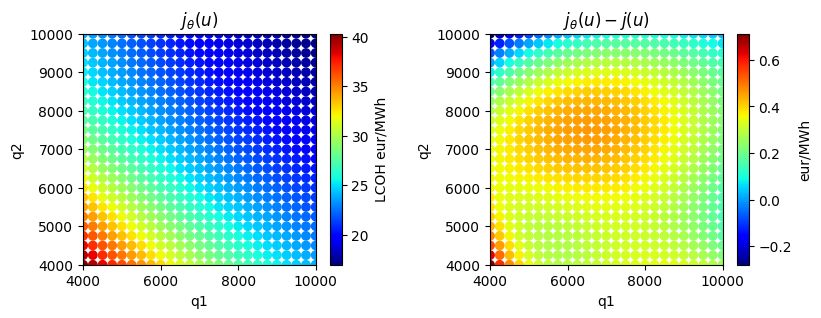

In [19]:
plt.figure(figsize = (9,3)) 
plt.subplots_adjust(wspace = 0.4) 
plt.subplot(1,2,1)

min = 4000
max = 10000

# APPROXIMATE SOLUTION SPACE WITH NEURAL NETWORK
x = np.linspace(min, max, 25)
U = np.meshgrid(x, x)
umesh = np.vstack([U[0].flatten(), U[1].flatten()]).T
jmesh = NN.model((umesh-mu)/min_max).numpy()*1e2 
plt.title(r'$j_{\theta}(u)$')
#c = plt.contourf(x, x, jmesh.reshape(25, 25), cmap = cm.jet)
c = plt.scatter(umesh[:,0], umesh[:,1], c = jmesh, cmap = cm.jet)
plt.colorbar(c, label = 'LCOH eur/MWh')
plt.xlabel('q1')
plt.ylabel('q2')
plt.xlim(min, max)
plt.ylim(min, max)

# TRUTH (DARTS)
plt.subplot(1,2,2)
umesh_truth = np.load('session5data/meshu.npy')                      
jmesh_truth = np.load('session5data/meshj.npy').reshape(-1,1)  
plt.title(r'$j_{\theta}(u)-j(u)$')
#c = plt.contourf(x, x, jmesh_truth.reshape(25, 25), cmap = cm.jet)
c = plt.scatter(umesh_truth[:,0], umesh_truth[:,1], c = jmesh_truth - jmesh, cmap = cm.jet)
plt.colorbar(c, label = 'eur/MWh')
plt.xlabel('q1')
plt.ylabel('q2')
plt.xlim(min, max)
plt.ylim(min, max)
plt.show() 

## <font color='Blue'>Optimize</font>

In [12]:
wells = {
    'INJ1': [15, 14, 1], 
    'INJ2': [45, 46, 1], 
    'PRD1': [15, 46, 1], 
    'PRD2': [45, 14, 1]
    }

data_x = []
data_y = []
u_evolution = []
j_evolution = []

o = optimizer(wells, NN, mu, min_max)
u = o.u
j = o.calculate_obj(u*o.su)
print('iter 0 \t, control vector =', u*o.su, '\t j =', j*1e2) 

Ni = 300  # number of outer iterations 
Nl = 10   # number of line iterations
C = o.covariance()
alpha0 = 0.1 # initial step size 

for outer in range(1, Ni+1):
    U = o.perturbation(u) # generate ensemble of perturbed controls [Nu x Np]  

    # gradient evaluation [Nu x 1]
    g, J = o.compute_gradient(u, j, U) # neural network
    
    for i in range(o.Np):
        data_x.append(U[:,i])
        data_y.append(J[i,0])
    
    alpha = alpha0
    inner = 0
    while inner <= Nl:
        un = o.update(u, alpha, -np.matmul(C,g)) # update of controls
        un = un.flatten()
        jn = o.calculate_obj(un * o.su)
        
        if jn < j or inner == Nl:
            u = un # update control with better value
            j = jn 
            
            u_evolution.append(un*o.su)
            j_evolution.append(jn*1e2)
            
            print('iter %d'%outer, '\t, control vector =', u*o.su, '\t j =', j*1e2) 
            break 
            
        else:
            alpha *= 0.5 # reduce step size
            
        inner = inner + 1

iter 0 	, control vector = [5533.24442569 4780.1758282 ] 	 j = 31.684982776641846
iter 1 	, control vector = [5533.14676944 4780.14824297] 	 j = 31.685364246368408
iter 2 	, control vector = [5633.14676944 4806.7911257 ] 	 j = 31.309685111045837
iter 3 	, control vector = [5633.06395812 4806.69346945] 	 j = 31.31023943424225
iter 4 	, control vector = [5632.96630187 4806.61324432] 	 j = 31.31076991558075
iter 5 	, control vector = [5633.51047775 4906.61324432] 	 j = 31.007230281829834
iter 6 	, control vector = [5733.51047775 4997.95259867] 	 j = 30.457928776741028
iter 7 	, control vector = [5733.4128215  4997.99332755] 	 j = 30.458107590675354
iter 8 	, control vector = [5733.39770697 4997.8956713 ] 	 j = 30.45841157436371
iter 9 	, control vector = [5682.96400408 5097.8956713 ] 	 j = 30.3079754114151
iter 10 	, control vector = [5782.96400408 5081.6612504 ] 	 j = 30.08343279361725
iter 11 	, control vector = [5882.96400408 5136.01010981] 	 j = 29.666200280189514
iter 12 	, control v

C:\Users\georgehadjisot\AppData\Local\Temp\ipykernel_28844\1072250331.py:147: RuntimeWarning: invalid value encountered in scalar divide
  if E1/E < 0.999:


ValueError: zero-size array to reduction operation minimum which has no identity

In [13]:
U

array([[10., 10.],
       [10., 10.]])

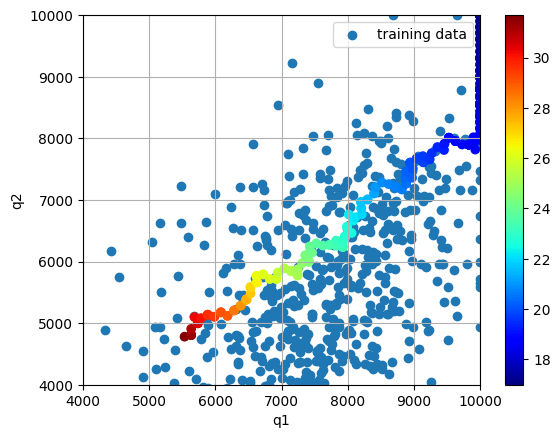

In [16]:
# plot evolution of training 
uevo = np.asarray(u_evolution)
jevo = np.asarray(j_evolution)

plt.figure()
plt.grid()
plt.scatter(train_x[:,0], train_x[:,1], label = 'training data') 
c = plt.scatter(uevo[:,0], uevo[:,1], c = jevo, cmap = 'jet')
plt.colorbar(c)
plt.xlabel('q1')
plt.ylabel('q2')
plt.legend() 
plt.xlim(o.min, o.max)
plt.ylim(o.min, o.max)
plt.show()